In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 8: Time series
**Due date: See the [Calendar](https://calendar.google.com/calendar/u/0/embed?src=7a04205ae91b85e82ebc74daddbf2933c6b6723b81abb966f0e69c66a996c43b@group.calendar.google.com&ctz=America/Vancouver&pli=1).**

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

## Submission instructions
<hr>
rubric={points:4}

You will receive marks for correctly submitting this assignment. 

Follow the homework instructions below and at the end of this file. 
There are also detailed [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023s/blob/main/docs/homework_instructions.md) on github.

- **You may work on this assignment in a group (group size <= 4) and submit your assignment as a group.** 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Upload the .ipynb file to Gradescope.
- **If the .ipynb file is too big or doesn't render on Gradescope for some reason, also upload a pdf or html in addition to the .ipynb.** 
- Make sure that your plots/output are rendered properly in Gradescope.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture, we had different measurements for each Location. How about this avocado sales dataset? For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

In [9]:
df_train.sort_values(by=["Date"])

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
50,2015-01-04,1.64,6182.81,1561.30,2958.17,0.00,1663.34,1663.34,0.00,0.00,organic,2015,WestTexNewMexico
51,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.00,conventional,2015,Atlanta
51,2015-01-04,1.93,17328.24,2357.18,12692.21,9.47,2269.38,2269.38,0.00,0.00,organic,2015,NewYork
51,2015-01-04,1.02,160130.15,4007.41,118435.79,1201.50,36485.45,20325.41,16160.04,0.00,conventional,2015,Indianapolis
51,2015-01-04,1.69,34190.37,3874.31,14945.34,32.45,15338.27,13793.22,1545.05,0.00,organic,2015,Plains
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,2017-09-24,2.23,14173.82,2804.46,10041.55,0.00,1327.81,1327.81,0.00,0.00,organic,2017,SanDiego
14,2017-09-24,1.40,10081.25,277.50,133.65,0.00,9670.10,9642.01,28.09,0.00,organic,2017,BuffaloRochester
14,2017-09-24,1.70,314818.19,89050.27,187831.17,962.78,36973.97,34708.41,2069.24,196.32,conventional,2017,Sacramento
14,2017-09-24,1.83,144890.83,55004.63,7796.72,126.19,81963.29,58921.39,23031.97,9.93,conventional,2017,StLouis


It looks like there's multiple rows for each date, corresponding to both different types of avocados (organic vs conventional) and regions. We can confirm that these are the only categorical features with separate measurements for each date below:

In [10]:
df_train.groupby(["Date", "region", "type"]).size().unique()

array([1])

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

We can calculate the time spanning the first and last dates in the training set:

In [11]:
max_date = df_train['Date'].max()
min_date = df_train['Date'].min()

weeks_dif = (max_date - min_date) / pd.Timedelta(weeks=1)
num_obs = df_train['Date'].nunique()

print(f"The total number of weeks in this dataset should be: {weeks_dif}")
print(f"The total number of observations we have is: {num_obs}")

The total number of weeks in this dataset should be: 142.0
The total number of observations we have is: 143


There are 142 weeks between the beginning and end date, and we have 143 observations. This makes sense, since the time strictly between the two dates wouldn't include both endpoints. So there is at least one observation for every week. 

We can also check if each categorical feature has observations for every date:

In [12]:
df_train['type'].value_counts()

conventional    7722
organic         7719
Name: type, dtype: int64

Looks like roughly even numbers of avocado types.

In [13]:
df_train['region'].value_counts()

Albany                 286
Sacramento             286
Northeast              286
NorthernNewEngland     286
Orlando                286
Philadelphia           286
PhoenixTucson          286
Pittsburgh             286
Plains                 286
Portland               286
RaleighGreensboro      286
RichmondNorfolk        286
Roanoke                286
SanDiego               286
Atlanta                286
SanFrancisco           286
Seattle                286
SouthCarolina          286
SouthCentral           286
Southeast              286
Spokane                286
StLouis                286
Syracuse               286
Tampa                  286
TotalUS                286
West                   286
NewYork                286
NewOrleansMobile       286
Nashville              286
Midsouth               286
BaltimoreWashington    286
Boise                  286
Boston                 286
BuffaloRochester       286
California             286
Charlotte              286
Chicago                286
C

Also almost the same number of observations per region, except for WestTexNewMexico which is missing 3.

We can also quickly confirm that this holds true for every date.

In [14]:
df_train.groupby(["Date", "region"]).size().value_counts()

2    7719
1       3
dtype: int64

In [15]:
df_train.groupby(["Date", "type"]).size().value_counts()

54    283
53      3
dtype: int64

For the most part the value counts are identical for every date. There's 3 dates that are missing one type of avocado, and 3 dates that are missing 1 region. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

In [16]:
df_train['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

These regions definitely have some overlap. It looks like for the most part they're individual cities or distinct smaller regions, but also a few broader regions ("Midsouth", "Northeast", "Southeast", "SouthCentral", "TotalUS", "West") which are likely an aggregation of the cities/regions within.  

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2023s/blob/main/lectures/19_time-series.ipynb), with some improvements.

In [17]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [18]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [19]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [20]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

### 1.4 `AveragePrice` baseline 
rubric={autograde:4}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

In [21]:
class BaselineRegressor:
    """
    A baseline regressor that predicts the same price next week as today's price.
    """
    def predict(self, X):
        return X['AveragePrice']

    def score(self, X, y):
        y_hat = self.predict(X)
        return r2_score(y, y_hat)

In [22]:
X_train = df_train.drop(columns=['AveragePriceNextWeek'])
y_train = df_train['AveragePriceNextWeek']

br = BaselineRegressor()

train_r2 = br.score(X_train, y_train)
train_r2

0.8285800937261841

In [23]:
X_test = df_test.drop(columns=['AveragePriceNextWeek'])
y_test = df_test['AveragePriceNextWeek']

test_r2 = br.score(X_test, y_test)
test_r2

0.7631780188583048

In [24]:
grader.check("q1.4")

q1.4 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 10

We'll start by getting a look at the training data. 

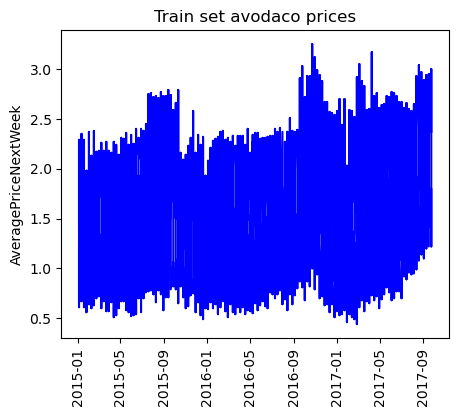

In [25]:
df_train = df_train.sort_values("Date")

plt.figure(figsize=(5,4))
plt.plot(df_train["Date"], df_train["AveragePriceNextWeek"], "b")
plt.xticks(rotation="vertical")
plt.ylabel("AveragePriceNextWeek")
plt.title("Train set avodaco prices");

There definitely looks to be a periodic pattern in the data, where around September prices get high, and they get low through the spring. 

We'll try three approaches:

1. Encode the time as days since 2015-01
2. Encode the time as the month
3. Encode the time as the season

### 1. Encoding the time as days since 2015-01

First, we add a "Days_since" column to indicate the days since the start of the dataset:

In [26]:
first_day = df_train["Date"].min()

df_train_days = df_train.assign(
    Days_since=df_train["Date"].apply(lambda x: (x - first_day).days)
)
df_test_days = df_test.assign(
    Days_since=df_test["Date"].apply(lambda x: (x - first_day).days)
)
df_train_days

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,Days_since
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany,1.24,0
13858,2015-01-04,0.94,461607.33,244152.26,165299.33,15302.75,36852.99,30884.29,5595.00,373.70,conventional,2015,SanDiego,0.82,0
1352,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.00,conventional,2015,Boston,1.10,0
13689,2015-01-04,1.33,9213.49,3727.52,4327.52,0.00,1158.45,1158.45,0.00,0.00,organic,2015,Sacramento,1.27,0
13520,2015-01-04,1.05,430138.88,110693.69,270107.61,9737.50,39600.08,39600.08,0.00,0.00,conventional,2015,Sacramento,1.09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9775,2017-09-24,2.06,70365.19,5244.89,22378.40,77.37,42664.53,42664.53,0.00,0.00,organic,2017,NewYork,2.04,994
9606,2017-09-24,1.65,1178504.26,77197.18,716125.04,599.08,384582.96,362090.67,22488.31,3.98,conventional,2017,NewYork,1.67,994
9437,2017-09-24,1.89,6852.14,155.62,218.47,0.00,6478.05,5656.66,821.39,0.00,organic,2017,NewOrleansMobile,1.97,994
6057,2017-09-24,1.82,19611.69,122.01,3577.52,0.00,15912.16,15912.16,0.00,0.00,organic,2017,HartfordSpringfield,2.06,994


Now that we have all of our features, we can split the training set.

In [27]:
X_train_days = df_train_days.drop(columns=['AveragePriceNextWeek'])
y_train_days = df_train_days['AveragePriceNextWeek']
X_train_days

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Days_since
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany,0
13858,2015-01-04,0.94,461607.33,244152.26,165299.33,15302.75,36852.99,30884.29,5595.00,373.70,conventional,2015,SanDiego,0
1352,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.00,conventional,2015,Boston,0
13689,2015-01-04,1.33,9213.49,3727.52,4327.52,0.00,1158.45,1158.45,0.00,0.00,organic,2015,Sacramento,0
13520,2015-01-04,1.05,430138.88,110693.69,270107.61,9737.50,39600.08,39600.08,0.00,0.00,conventional,2015,Sacramento,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9775,2017-09-24,2.06,70365.19,5244.89,22378.40,77.37,42664.53,42664.53,0.00,0.00,organic,2017,NewYork,994
9606,2017-09-24,1.65,1178504.26,77197.18,716125.04,599.08,384582.96,362090.67,22488.31,3.98,conventional,2017,NewYork,994
9437,2017-09-24,1.89,6852.14,155.62,218.47,0.00,6478.05,5656.66,821.39,0.00,organic,2017,NewOrleansMobile,994
6057,2017-09-24,1.82,19611.69,122.01,3577.52,0.00,15912.16,15912.16,0.00,0.00,organic,2017,HartfordSpringfield,994


We'll use a Ridge regression model here, so we'll need to preprocess the data. Since there are both numerical and categorical columns, we'll need to use a column transformer.  

In [28]:
numeric_feats = ['AveragePrice', '4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags']
days_categorical_feats = ['Days_since', 'type', 'region']
drop_feats = ['Date', 'year', 'Total Volume', 'Total Bags']

In [29]:
days_preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(handle_unknown='ignore'), days_categorical_feats),
    ('drop', drop_feats)
)

We'll tune the model's complexity, and score the best model: 

In [30]:
param_grid = {
    "ridge__alpha": [1, 10, 100, 250, 500, 1000],
}

days_pipe = make_pipeline(days_preprocessor, Ridge())

days_grid_search = GridSearchCV(
    days_pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
)

days_grid_search.fit(X_train_days, y_train_days)

print(days_grid_search.best_score_, days_grid_search.best_params_)

0.8294972534557029 {'ridge__alpha': 100}


### 2. Encoding the time as the month

For this section, we'll take the same approach as the previous one, except this time adding a "Month" column instead of "Days_since"

In [31]:
df_train_month = df_train.assign(Month=df_train["Date"].apply(lambda x: x.month_name())).reset_index().sort_values("Date")
df_test_month = df_test.assign(Month=df_test["Date"].apply(lambda x: x.month_name())).reset_index().sort_values("Date")
df_train_month

,index,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,Month
0,0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany,1.24,January
78,7605,2015-01-04,1.25,54495.54,47721.51,1723.40,0.00,5050.63,5050.63,0.00,0.00,organic,2015,LosAngeles,1.08,January
77,7436,2015-01-04,0.85,2682159.95,1837999.65,524430.47,64225.78,255504.05,215571.80,36981.72,2950.53,conventional,2015,LosAngeles,0.85,January
76,5746,2015-01-04,1.06,332208.14,6387.60,267593.62,165.35,58061.57,55401.31,2660.26,0.00,conventional,2015,HartfordSpringfield,1.38,January
75,4563,2015-01-04,1.70,7446.43,361.76,5025.58,0.00,2059.09,746.43,1312.66,0.00,organic,2015,Detroit,1.87,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,3184,2017-09-24,1.79,182714.75,4560.35,68227.85,614.28,109312.27,22411.54,86693.86,206.87,conventional,2017,CincinnatiDayton,1.86,September
15361,4198,2017-09-24,1.60,499761.73,125319.71,161435.81,191.97,212814.24,75919.39,136894.85,0.00,conventional,2017,Denver,1.47,September
15360,4874,2017-09-24,1.96,113272.89,2101.47,48552.76,24966.57,37652.09,26290.10,3741.32,7620.67,conventional,2017,GrandRapids,2.09,September
15371,14507,2017-09-24,2.06,19095.21,10381.10,8026.03,0.00,688.08,688.08,0.00,0.00,organic,2017,SanFrancisco,2.04,September


In [32]:
X_train_month = df_train_month.drop(columns=['AveragePriceNextWeek']).drop(columns=['index'])
y_train_month = df_train_month['AveragePriceNextWeek']
X_train_month

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany,January
78,2015-01-04,1.25,54495.54,47721.51,1723.40,0.00,5050.63,5050.63,0.00,0.00,organic,2015,LosAngeles,January
77,2015-01-04,0.85,2682159.95,1837999.65,524430.47,64225.78,255504.05,215571.80,36981.72,2950.53,conventional,2015,LosAngeles,January
76,2015-01-04,1.06,332208.14,6387.60,267593.62,165.35,58061.57,55401.31,2660.26,0.00,conventional,2015,HartfordSpringfield,January
75,2015-01-04,1.70,7446.43,361.76,5025.58,0.00,2059.09,746.43,1312.66,0.00,organic,2015,Detroit,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,2017-09-24,1.79,182714.75,4560.35,68227.85,614.28,109312.27,22411.54,86693.86,206.87,conventional,2017,CincinnatiDayton,September
15361,2017-09-24,1.60,499761.73,125319.71,161435.81,191.97,212814.24,75919.39,136894.85,0.00,conventional,2017,Denver,September
15360,2017-09-24,1.96,113272.89,2101.47,48552.76,24966.57,37652.09,26290.10,3741.32,7620.67,conventional,2017,GrandRapids,September
15371,2017-09-24,2.06,19095.21,10381.10,8026.03,0.00,688.08,688.08,0.00,0.00,organic,2017,SanFrancisco,September


In [33]:
month_categorical_feats = ['Month', 'type', 'region']

In [34]:
month_preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(handle_unknown='ignore'), month_categorical_feats),
    ('drop', drop_feats)
)

In [35]:
month_pipe = make_pipeline(month_preprocessor, Ridge())

month_grid_search = GridSearchCV(
    month_pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
)

month_grid_search.fit(X_train_month, y_train_month)

print(month_grid_search.best_score_, month_grid_search.best_params_)

0.8294222520693622 {'ridge__alpha': 100}


### 3. Encoding the time as the season

Again, we'll take the same approach, this time converting the "Month" columns we made previously into seasons.

In [36]:
def get_season(month):
    # remember this is Australia
    WINTER_MONTHS = ["December", "January", "February"] 
    AUTUMN_MONTHS = ["September", "October", "November"]
    SUMMER_MONTHS = ["June", "July", "August"]
    SPRING_MONTHS = ["March", "April", "May"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"

In [37]:
df_train_season = df_train_month.assign(Season=df_train_month["Month"].apply(get_season)).drop(columns=['Month'])
df_test_season = df_train_month.assign(Season=df_test_month["Month"].apply(get_season)).drop(columns=['Month'])
df_train_season

,index,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,Season
0,0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany,1.24,Winter
78,7605,2015-01-04,1.25,54495.54,47721.51,1723.40,0.00,5050.63,5050.63,0.00,0.00,organic,2015,LosAngeles,1.08,Winter
77,7436,2015-01-04,0.85,2682159.95,1837999.65,524430.47,64225.78,255504.05,215571.80,36981.72,2950.53,conventional,2015,LosAngeles,0.85,Winter
76,5746,2015-01-04,1.06,332208.14,6387.60,267593.62,165.35,58061.57,55401.31,2660.26,0.00,conventional,2015,HartfordSpringfield,1.38,Winter
75,4563,2015-01-04,1.70,7446.43,361.76,5025.58,0.00,2059.09,746.43,1312.66,0.00,organic,2015,Detroit,1.87,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,3184,2017-09-24,1.79,182714.75,4560.35,68227.85,614.28,109312.27,22411.54,86693.86,206.87,conventional,2017,CincinnatiDayton,1.86,Autumn
15361,4198,2017-09-24,1.60,499761.73,125319.71,161435.81,191.97,212814.24,75919.39,136894.85,0.00,conventional,2017,Denver,1.47,Autumn
15360,4874,2017-09-24,1.96,113272.89,2101.47,48552.76,24966.57,37652.09,26290.10,3741.32,7620.67,conventional,2017,GrandRapids,2.09,Autumn
15371,14507,2017-09-24,2.06,19095.21,10381.10,8026.03,0.00,688.08,688.08,0.00,0.00,organic,2017,SanFrancisco,2.04,Autumn


In [38]:
X_train_season = df_train_season.drop(columns=['AveragePriceNextWeek']).drop(columns=['index'])
y_train_season = df_train_season['AveragePriceNextWeek']
X_train_season

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Season
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany,Winter
78,2015-01-04,1.25,54495.54,47721.51,1723.40,0.00,5050.63,5050.63,0.00,0.00,organic,2015,LosAngeles,Winter
77,2015-01-04,0.85,2682159.95,1837999.65,524430.47,64225.78,255504.05,215571.80,36981.72,2950.53,conventional,2015,LosAngeles,Winter
76,2015-01-04,1.06,332208.14,6387.60,267593.62,165.35,58061.57,55401.31,2660.26,0.00,conventional,2015,HartfordSpringfield,Winter
75,2015-01-04,1.70,7446.43,361.76,5025.58,0.00,2059.09,746.43,1312.66,0.00,organic,2015,Detroit,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,2017-09-24,1.79,182714.75,4560.35,68227.85,614.28,109312.27,22411.54,86693.86,206.87,conventional,2017,CincinnatiDayton,Autumn
15361,2017-09-24,1.60,499761.73,125319.71,161435.81,191.97,212814.24,75919.39,136894.85,0.00,conventional,2017,Denver,Autumn
15360,2017-09-24,1.96,113272.89,2101.47,48552.76,24966.57,37652.09,26290.10,3741.32,7620.67,conventional,2017,GrandRapids,Autumn
15371,2017-09-24,2.06,19095.21,10381.10,8026.03,0.00,688.08,688.08,0.00,0.00,organic,2017,SanFrancisco,Autumn


In [39]:
season_categorical_feats = ['Season', 'type', 'region']

In [40]:
season_preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(handle_unknown='ignore'), season_categorical_feats),
    ('drop', drop_feats)
)

In [41]:
season_pipe = make_pipeline(season_preprocessor, Ridge())

season_grid_search = GridSearchCV(
    season_pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
)

season_grid_search.fit(X_train_season, y_train_season)

print(season_grid_search.best_score_, season_grid_search.best_params_)

0.8290432760091611 {'ridge__alpha': 100}


### Evaluating the best model

In [42]:
print(f"The Days_since ecoding cv score was: {days_grid_search.best_score_}\nThe Month ecoding cv score was: {month_grid_search.best_score_}\nThe Season ecoding cv score was: {season_grid_search.best_score_}")

The Days_since ecoding cv score was: 0.8294972534557029
The Month ecoding cv score was: 0.8294222520693622
The Season ecoding cv score was: 0.8290432760091611


They're all quite close, but the Days_since encoding cv score is the highest, so we'll test that one against our test set, using the optimized alpha we obtained.

In [43]:
best_pipe = make_pipeline(days_preprocessor, Ridge(alpha=100))

In [44]:
df_test = df_test_days.sort_values("Date")
X_test = df_test.drop(columns=['AveragePriceNextWeek'])
y_test = df_test['AveragePriceNextWeek']

In [45]:
best_pipe.fit(X_train_days, y_train_days)
best_pipe.score(X_test, y_test)

0.8048594923983883

This looks like a good score, a fair bit better than the baseline!

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: very short answer questions

Each question is worth 2 points.

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:4}

The following questions pertain to Lecture 19 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 4

1. Any time series that's collected on regular workdays. These datasets would be missing data from weekends, and even if those were accounted for, it's further complicated by statutory holidays that are dispersed irregularly throughout the year. 

2. Creating lagged versions of the features would struggle with unequally spaced timepoints. If you were trying to create an extra feature that included the previous day's level of some variable, if the data was unequally spaced you may be missing data from the previous day meaning you'd need to impute/exlude data from both the previous day and the current day. 

    Encoding the date as one or more features could also have issues from unequally spaced timepoints. It may cause there to be strange jumps in the data, making it difficult to discern the true pattern.  

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Survival analysis
rubric={points:6}

The following questions pertain to [Lecture 20](https://github.com/UBC-CS/cpsc330-2023s/blob/main/lectures/20_survival-analysis.ipynb) on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. This biases the data, because we do not have complete information for people who haven't churned yet. They will still stay with the service for an unknown period of time, so any analysis will underestimate the real survival times. 

2. We don't have enough information to answer. It's possible that people who have been with the service for a very long time actually have higher retention, and that people who just joined are more likely to immediately cancel (imagine a service with a great welcome offer, but once people have gotten that they often immediately leave). It's also possible that it's a more linear relationship, where the longer you stay the higher chance you'll cancel. It's situational. 

3. If the survival curve is flat over a range of dates, that means people do not tend to cancel their subscription between those dates. Hense the % who survive from the beginning date compared to the end date is roughly the same. 

<!-- END QUESTION -->

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
4. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

![](img/eva-well-done.png)